# Semantic Segmentation

## Overview
Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class.
So, let's say we have the following image.

![](https://lh3.googleusercontent.com/-ELUnFgFJqUU/XPPXOOmhfMI/AAAAAAAAAP0/2cabsTI9uGUYxM3O3w4EOxjR_iJvEQAvACK8BGAs/s374/index3.png)

And then given the above image its semantically segmentated image would be the following

![](https://lh3.googleusercontent.com/-gdUavPeOxdg/XPPXQngAnvI/AAAAAAAAAQA/yoksBterCGQGt-lv3aX4kfyMUDXTar7yACK8BGAs/s374/index4.png)

As you can see, that each pixel in the image is classified to its respective class.


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
import os 
import tarfile
import shutil
import urllib.request

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
path='VOC'
def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path
  
  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")
 
get_archive(path,url)
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

## Helper Functions

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np

"""Various RGB palettes for coloring segmentation labels."""

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

## Code (25 pt)

### 1. Implement Data Loader for training and validation (5 pt)

In [ ]:
import os 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from matplotlib import cm

# You can modify this class 
class VocDataset(Dataset):
  def __init__(self, dir, color_map, input_transforms=None, target_transforms=None):
    self.input_transforms = input_transforms
    self.target_transforms = target_transforms
    self.root=os.path.join(dir,'VOCdevkit/VOC2007')
    self.target_dir=os.path.join(self.root,'SegmentationClass')
    self.images_dir=os.path.join(self.root,'JPEGImages')
    file_list = os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in tuple(open(file_list, "r"))]
    self.color_map=color_map

  def convert_to_segmentation_mask(self,mask):
    # This function converts color channels of semgentation masks to number of classes
    # Semantic Segmentation requires a segmentation mask to be a NumPy array with the shape
    # This part is implemented for displaying colorized results in subpart 3
    # YOUR CODE HERE:

    
    temp = mask.cpu().numpy()
    #convert gray scale to color
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, 19):
        r[temp == l] = self.color_map[l][0]
        g[temp == l] = self.color_map[l][1]
        b[temp == l] = self.color_map[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    rgb  = cv2.cvtColor(rgb.astype('float32'), cv2.COLOR_RGB2BGR) 
    return rgb


  def __len__(self):
    return len(os.listdir(self.target_dir))

  def __getitem__(self,index):
    # YOUR CODE HERE:
    img_name = self.files[index]
    img_path = os.path.join(self.root, 'JPEGImages', img_name+'.jpg')
    image = Image.open(img_path)
    
    image = cv2.imread(img_path)
    seg_image_path = os.path.join(self.root,'SegmentationClass',img_name+'.png')
    
    seg_img = cv2.imread(seg_image_path)

    seg_img = cv2.cvtColor(seg_img,cv2.COLOR_BGR2RGB)
    img_label = np.zeros((seg_img.shape[0],seg_img.shape[1]))

    for i in range(len(self.color_map)):
      color = self.color_map[i]
      im = seg_img == color
      idxs = np.all(im, axis=-1)
      img_label[idxs] = [i]
    image = Image.fromarray(image)
    img_label = Image.fromarray(img_label)
    if self.input_transforms is not None:
      image = self.input_transforms(image)
    if self.target_transforms is not None:
      img_label = self.target_transforms(img_label)
    return image, img_label

input_transform = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor(), transforms.Normalize([.485, .456, .406], [.229, .224, .225])])
batch_size=64
target_transform = transforms.Compose([transforms.Resize((128,128)) ,transforms.ToTensor()])
train_loader = DataLoader(VocDataset(dir=os.getcwd(),color_map=VOC_COLORMAP,input_transforms=input_transform,target_transforms=target_transform), batch_size=batch_size, shuffle=True)



###2. Define model and training code (15 pt)
Implement FCN-32 model. You can use encoder as pretrained model provided by torchvision.       

In [ ]:
import torch
import torch.nn.functional as F

print(torch.cuda.is_available())
class FCN32(torch.nn.Module):
  def __init__(self, n_classes):
    # YOUR CODE HERE:
    super().__init__()
    self.backbone = models.vgg16(pretrained=True).features
    # self.backbone = models.resnet18(pretrained=True)
    for param in self.backbone.parameters():
        param.requires_grad = False
    self.fc32 = nn.Sequential(
    nn.Conv2d(512, 4096, 3),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Conv2d(4096, 4096, 1),
    nn.ReLU(inplace=True),
    nn.Dropout()
    )
    self.score = nn.Conv2d(4096, n_classes, 1)

  def forward(self,x):
    backbone = self.backbone(x)
    fc32 = self.fc32(backbone)
    score = self.score(fc32)
    return F.upsample_bilinear(score, x.size()[2:])
    # return F.interpolate(score, x.size()[2:])


False


 Training code for the semantic segmentation model. Implment both training and validation parts.  

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = FCN32(n_classes=22).to(device)

criterion = nn.CrossEntropyLoss() ## TODO: Add loss function
optimizer = optim.SGD(net.parameters(), lr=.1, momentum=.9) ## TODO: Add optimizer

epochs = 10
train_loss_list = []
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader,0)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor).squeeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs,labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # if i%100==0:
        #   print("error : ", running_loss)
    print(f"Epoch {epoch+1}, loss: {running_loss}")

    train_loss_list.append(running_loss)

print("Finished Training!") 

PATH = './voc_net.pth'
torch.save(net.state_dict(), PATH)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


Epoch 0, loss: 20.25866138935089


0it [00:00, ?it/s]

Epoch 1, loss: 9.76380717754364


0it [00:00, ?it/s]

Epoch 2, loss: 8.67299497127533


0it [00:00, ?it/s]

Epoch 3, loss: 8.19132113456726


0it [00:00, ?it/s]

Epoch 4, loss: 7.592608630657196


0it [00:00, ?it/s]

Epoch 5, loss: 7.158393025398254


0it [00:00, ?it/s]

Epoch 6, loss: 6.636596441268921


0it [00:00, ?it/s]

Epoch 7, loss: 6.42903071641922


0it [00:00, ?it/s]

Epoch 8, loss: 6.225550949573517


0it [00:00, ?it/s]

Epoch 9, loss: 5.935155630111694
Finished Training!


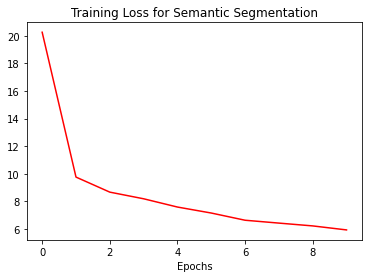

In [ ]:
#plot training loss:
plt.figure()
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'r-')
plt.title("Training Loss for Semantic Segmentation")
plt.xlabel("Epochs")
plt.show()

### 3. Inference for semantic segmentation (5 pt)

Implement the inference code for semantic segmentation. Display the visualization results of the model. Plot the image and colorized image (similar to the results in overview). 

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


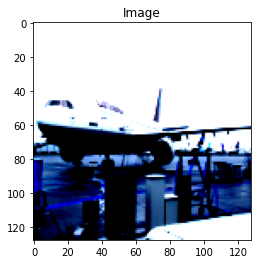

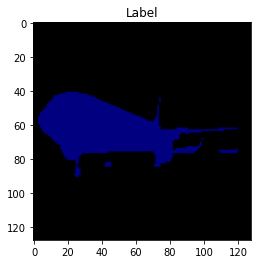

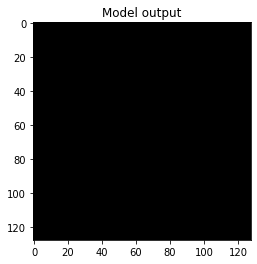

In [ ]:
# YOUR CODE HERE:
import torch

PATH = './voc_net.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = FCN32(22).to(device)
net.load_state_dict(torch.load(PATH))
import torchvision.transforms as tf

# import torch.functional as F
def predict(model, image):
  with torch.no_grad():
    model.eval()
    output = model(image) #(N, K, W, H)
    Prd = tf.Resize((128,128))(output[0])
    seg = torch.argmax(Prd, dim=0).cpu().detach()
    return seg


voc = VocDataset(os.getcwd(),VOC_COLORMAP,input_transforms=input_transform, target_transforms=target_transform)
im, label = voc.__getitem__(1)

out = voc.convert_to_segmentation_mask(label.squeeze(0))

Img = torch.autograd.Variable(im, requires_grad=False).to(device).unsqueeze(0)
model_output = predict(net,Img)


model_output = voc.convert_to_segmentation_mask(model_output)


plt.figure()
plt.title('Image')
plt.imshow(im.numpy().transpose(1,2,0))
plt.show()

plt.figure()
plt.title('Label')
plt.imshow(out)
plt.show()

plt.figure()
plt.title('Model output')
plt.imshow(model_output)
plt.show()

# with torch.no_grad():
#     Prd = net(Img)  # Run net
# # resize to orginal size
# Prd = tf.Resize((height_orgin,widh_orgin))(Prd[0])
# #Convert probability to class map
# seg = torch.argmax(Prd, 0).cpu().detach().numpy()  
# plt.imshow(seg)  # display image
# plt.show()





# plt.imshow(im)
# plt.show()
# predict(net,im)

## Write-up (5 pt)
* Describe the properties of segmentation model
- A segmentation model typically contains a backbone as the feature extracter model such as resNet50, vgg16, etc. The backbone model extracts the features. Later the fully connected layers in the backbone are usually replaced with fully convolution layers (1x1 convolution). The the layers are upsampled to the volume equal to number of output classes so that each pixel can be classifed into individually.

* Describe the evaluation metric (IoU) for segmentation model 
IoU (Intersection over Union) is the metric that measures the number of pixels common between the target and prediction masks divided by the total number of pixels present across both masks. In other words, it is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth.